The equation we are testing is

$$
\begin{cases}
|u'(x)|= 1, \qquad\text{for}\; -1<x<1,\\
u(-1) = u(1) = 0.
\end{cases}
$$ 





In [ ]:
# Import libraries
from numpy import linalg
import pandas as pd
import numpy as np
import math
# !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import torch.nn.init as init
from torch import autograd

from torch import nn, optim
from time import time

In [ ]:
eps = 0.0001
def u_star_func(x):
    x = x[1:-1]
    result = 1-np.abs(x) + eps*(np.exp(-1/eps) - np.exp(-1/eps*np.abs(x)))
    return np.hstack((0,result,0))

In [ ]:
# Discritize the interval
a = -1
b = 1
step = (b-a)/100
x_init_np = np.arange(start=a, stop=b+step, step=step)
x_init = torch.tensor(x_init_np, requires_grad= False)
one_init = x_init/x_init
one_init
x_init

tensor([-1.0000e+00, -9.8000e-01, -9.6000e-01, -9.4000e-01, -9.2000e-01,
        -9.0000e-01, -8.8000e-01, -8.6000e-01, -8.4000e-01, -8.2000e-01,
        -8.0000e-01, -7.8000e-01, -7.6000e-01, -7.4000e-01, -7.2000e-01,
        -7.0000e-01, -6.8000e-01, -6.6000e-01, -6.4000e-01, -6.2000e-01,
        -6.0000e-01, -5.8000e-01, -5.6000e-01, -5.4000e-01, -5.2000e-01,
        -5.0000e-01, -4.8000e-01, -4.6000e-01, -4.4000e-01, -4.2000e-01,
        -4.0000e-01, -3.8000e-01, -3.6000e-01, -3.4000e-01, -3.2000e-01,
        -3.0000e-01, -2.8000e-01, -2.6000e-01, -2.4000e-01, -2.2000e-01,
        -2.0000e-01, -1.8000e-01, -1.6000e-01, -1.4000e-01, -1.2000e-01,
        -1.0000e-01, -8.0000e-02, -6.0000e-02, -4.0000e-02, -2.0000e-02,
         8.8818e-16,  2.0000e-02,  4.0000e-02,  6.0000e-02,  8.0000e-02,
         1.0000e-01,  1.2000e-01,  1.4000e-01,  1.6000e-01,  1.8000e-01,
         2.0000e-01,  2.2000e-01,  2.4000e-01,  2.6000e-01,  2.8000e-01,
         3.0000e-01,  3.2000e-01,  3.4000e-01,  3.6

In [ ]:
input_size = 1
output_size = 1
k = 16

model = nn.Sequential(nn.Linear(input_size, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),

                      nn.Linear(k, output_size),
                      nn.Tanh(),

                      )
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=16, bias=True)
  (5): Tanh()
  (6): Linear(in_features=16, out_features=1, bias=True)
  (7): Tanh()
)


In [ ]:
import matplotlib.pyplot as plt
def draw_result(lst_iter, lst_loss, title='Loss'):
    plt.plot(lst_iter, lst_loss, '-b', label='loss')
    
    plt.xlabel("n iteration")
    plt.legend(loc='upper left')
    plt.title(title)

    # save image
    plt.savefig(title +".png")  # should before show method

    # show
    plt.show()

def draw_graph(lst_iter, lst_loss, lst_acc, title):
    plt.plot(lst_iter, lst_loss, '-b', label='true')
    plt.plot(lst_iter, lst_acc, '-r', label='neural network')

    plt.xlabel("x")
    plt.legend(loc='upper left')
    plt.title(title)

    # save image
    plt.savefig(title+".png")  # should before show method

    # show
    plt.show()

## Training

In [ ]:
def run_train(lr = 0.001, num_e = 1000):
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    time0 = time()
    num_e = num_e
    iter = []
    test_error_vec = []
    # print(model.parameters())
    scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.1)
    scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
    for e in range(num_e):
        running_loss = 0
        
        optimizer.zero_grad() # call zero_Grad
        
        u_hat = torch.tensor(np.array([]))
        for x in x_init_np:
            x_tensor = torch.tensor(np.array([x]), requires_grad= True)
            temp = model(x_tensor.float())
            u_hat = torch.hstack([u_hat, temp])

        loss = (u_hat[0]**2 + u_hat[-1]**2 )/2.

        d1u_hat = u_hat.clone()  
        d1u_hat[0] = 0. #assign like this instead of u_hat[0] = 0 to avoid inplace error by pytorch backprop
        d1u_hat[-1] = 0.
        d1u_hat[1:-1] = (-u_hat[0:-2] + u_hat[2:])/(2*step)
        # d1u_hat[1:-1] = (u_hat[2:] - u_hat[1:-1])/(step)
        
        d2u_hat = u_hat.clone()    
        d2u_hat[1:-1] = (u_hat[0:-2] + u_hat[2:] - 2*u_hat[1:-1])/step**2     
        
        # loss and backward
        loss += torch.mean(((d1u_hat[1:-1])**2- one_init[1:-1])**2) 
        print(loss)
        loss.backward()

        optimizer.step() 

        running_loss += loss.clone().item()    
        if (e % 50 == 0):
            print(f"The running loss at {e+1} iteration is: {running_loss}")
        test_error_vec.append(running_loss)
        iter.append(e)

    draw_result(iter, test_error_vec)
    # print(f"The running loss at {num_e} iteration is: {test_error_vec[-1]}")
    y_true = u_star_func(x_init_np)
    draw_graph(x_init_np, y_true, u_hat.clone().detach().numpy(), 'Solutions')
    print(np.mean(np.square(y_true -  u_hat.clone().detach().numpy())))       

Streaming output truncated to the last 5000 lines.
tensor(0.0575, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0566, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0555, dtype=torch.float64, grad_fn=<AddBackward0>)
The running loss at 101 iteration is: 0.055483297100910926
tensor(0.0545, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0536, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0526, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0516, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0508, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0498, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0489, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0482, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0474, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0466, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0460, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(0.0453, dtype=torch.float64, grad_fn=<AddBa

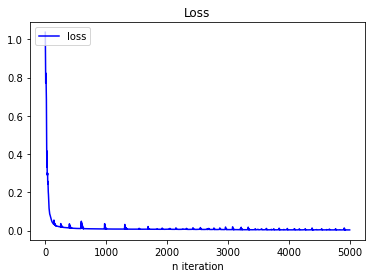

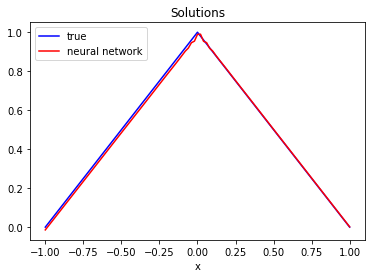

0.00013628851013189368
Time = 265.5853500366211


In [ ]:
def u_star_func(x):
    x = x[1:-1]
    result = 1-np.abs(x) # -1+np.abs(x) #+ eps*(np.exp(-1/eps) - np.exp(-1/eps*np.abs(x)))
    return np.hstack((0,result,0))
time0 = time()
run_train(lr=0.01, num_e= 5000)
print(f"Time = {time() - time0}")

In [ ]:
1.36*1e-4 -0.00013628851013189368

-2.8851013189365817e-07

## plot

In [ ]:
def evaluate_np(x_data_np):
    u_hat = []
    for x in x_data_np:
        x_tensor = torch.tensor(np.array([x]), requires_grad= True)
        temp = model(x_tensor.float())
        u_hat.append(temp.clone().item())
        # u_hat = torch.hstack([u_hat, temp])
    return u_hat

In [ ]:
def evaluate_error_np(x_data_np):
    y_pred = evaluate_np(x_data_np)
    y_true = u_star_func(x_data_np)
    return np.mean(np.square(y_true -  y_pred))

In [ ]:
# Discritize the interval
a = 0
b = 1
step = (b-a)/100
x_init_np = np.arange(start=a, stop=b+step, step=step)

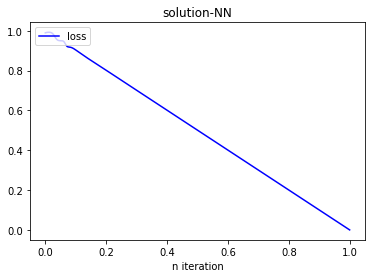

0.0009819712237057136

In [ ]:
x_init_np2 = np.arange(start=a, stop=b+step/10, step=step/10)
x_init2 = torch.tensor(x_init_np2, requires_grad= True)
# print(x_init)
# print(x_init2.shape)
y_pred2 = evaluate_np(x_init_np2)

draw_result(x_init_np2, y_pred2, 'solution-NN')
evaluate_error_np(x_init_np2)

In [ ]:
step_size = []
error = []
for k in [4,6,8,10,12, 14, 26]:
    x_vec = np.arange(start=a, stop=b+step/k, step=step/k)
    # x_vec_tensor = torch.tensor(x_vec, requires_grad= True)
    y_pred = evaluate_np(x_vec)
    error.append(evaluate_error_np(x_vec))
    step_size.append(step/k)

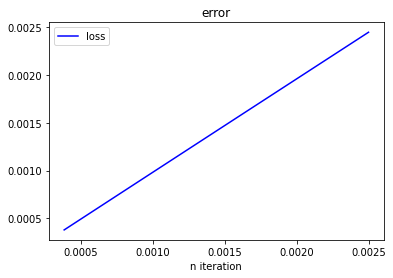

[0.0025, 0.0016666666666666668, 0.00125, 0.001, 0.0008333333333333334, 0.0007142857142857143, 0.0003846153846153846]


In [ ]:
draw_result(step_size[::-1], error[::-1], 'error')
print(step_size)